In [1]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf

In [2]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
cases20_additional = pd.read_csv('Data/ltla_2023-12-14 (1).csv')
cases20_additional.rename(columns={'newCasesBySpecimenDate':'value','areaCode':'area_code','areaName':'area_name'},inplace=True)
cases20_additional.drop(columns=['areaType','cumCasesBySpecimenDate','cumCasesBySpecimenDateRate'],inplace=True)
cases20_additional = cases20_additional[cases20_additional['area_name'].isin(cases20['area_name'].values)]
cases20_additional['date'] = pd.to_datetime(cases20_additional['date'])
cases20_additional = cases20_additional[cases20_additional['date'] < '2020-11-01']
cases20_additional = cases20_additional[cases20_additional['date'] >= '2020-10-01']
cases20 = pd.concat([cases20,cases20_additional]).sort_index()
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases = pd.concat([cases20,cases21])
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date', inplace=True)
cases.sort_index(inplace=True)
weekly_counts_total = cases.groupby(['area_code','area_name']).rolling(7).sum().reset_index()
# Convert incidence to a proportion to allow for cross-LTLA comparison
weekly_counts_total = pd.merge(weekly_counts_total,pop,on='area_code')
weekly_counts_total['incidence'] = weekly_counts_total['value'] / weekly_counts_total['population']

In [3]:
# Add in the ITL regions for spatial detrending
npis = pd.read_csv('Data/England_LTLA_NHSER.csv')
npis = npis[['NHSER_name','LTLA_name']]
npis.rename(columns={'NHSER_name':'region','LTLA_name':'ltla20nm'},inplace=True)
npis.drop_duplicates(inplace=True)

manual_dat = pd.DataFrame({'ltla20nm': ['Wycombe','South Bucks','Chiltern','Aylesbury Vale','Cornwall and Isles of Scilly', 'Hackney and City of London'], \
                           'region': ['South East', 'South East', 'South East', 'South East', 'South West', 'London']})
npis = pd.concat([npis,manual_dat])

In [4]:
# Cases with ITL regions
cases_region = pd.merge(cases.reset_index(), npis, left_on='area_name', right_on='ltla20nm')
cases_region.drop(columns='ltla20nm',inplace=True)

In [5]:
# Add in the ITL regions for spatial detrending
weekly_counts_total = pd.merge(weekly_counts_total, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_total.drop(columns='ltla20nm',inplace=True)

In [6]:
# Get the regional mean inicidences and spatially detrend
regional_mean_total = weekly_counts_total.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean_total.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_total = pd.merge(weekly_counts_total, regional_mean_total, on=['region', 'date'])
weekly_counts_total['detrended'] = weekly_counts_total['incidence'] - weekly_counts_total['regional_mean_incidence']

In [7]:
# Convert to wide format for ease of future calculations
wide_data_total = weekly_counts_total.pivot(index='date', columns='area_name', values='detrended')
wide_data_incidence = weekly_counts_total.pivot(index='date', columns='area_name', values='incidence')

In [8]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [9]:
# Get signals long windows
ews_10total, norm_ews_10total = calculate_ews_rolling(wide_data_total,window_size=10)
ews_30total, norm_ews_30total = calculate_ews_rolling(wide_data_total,window_size=30)

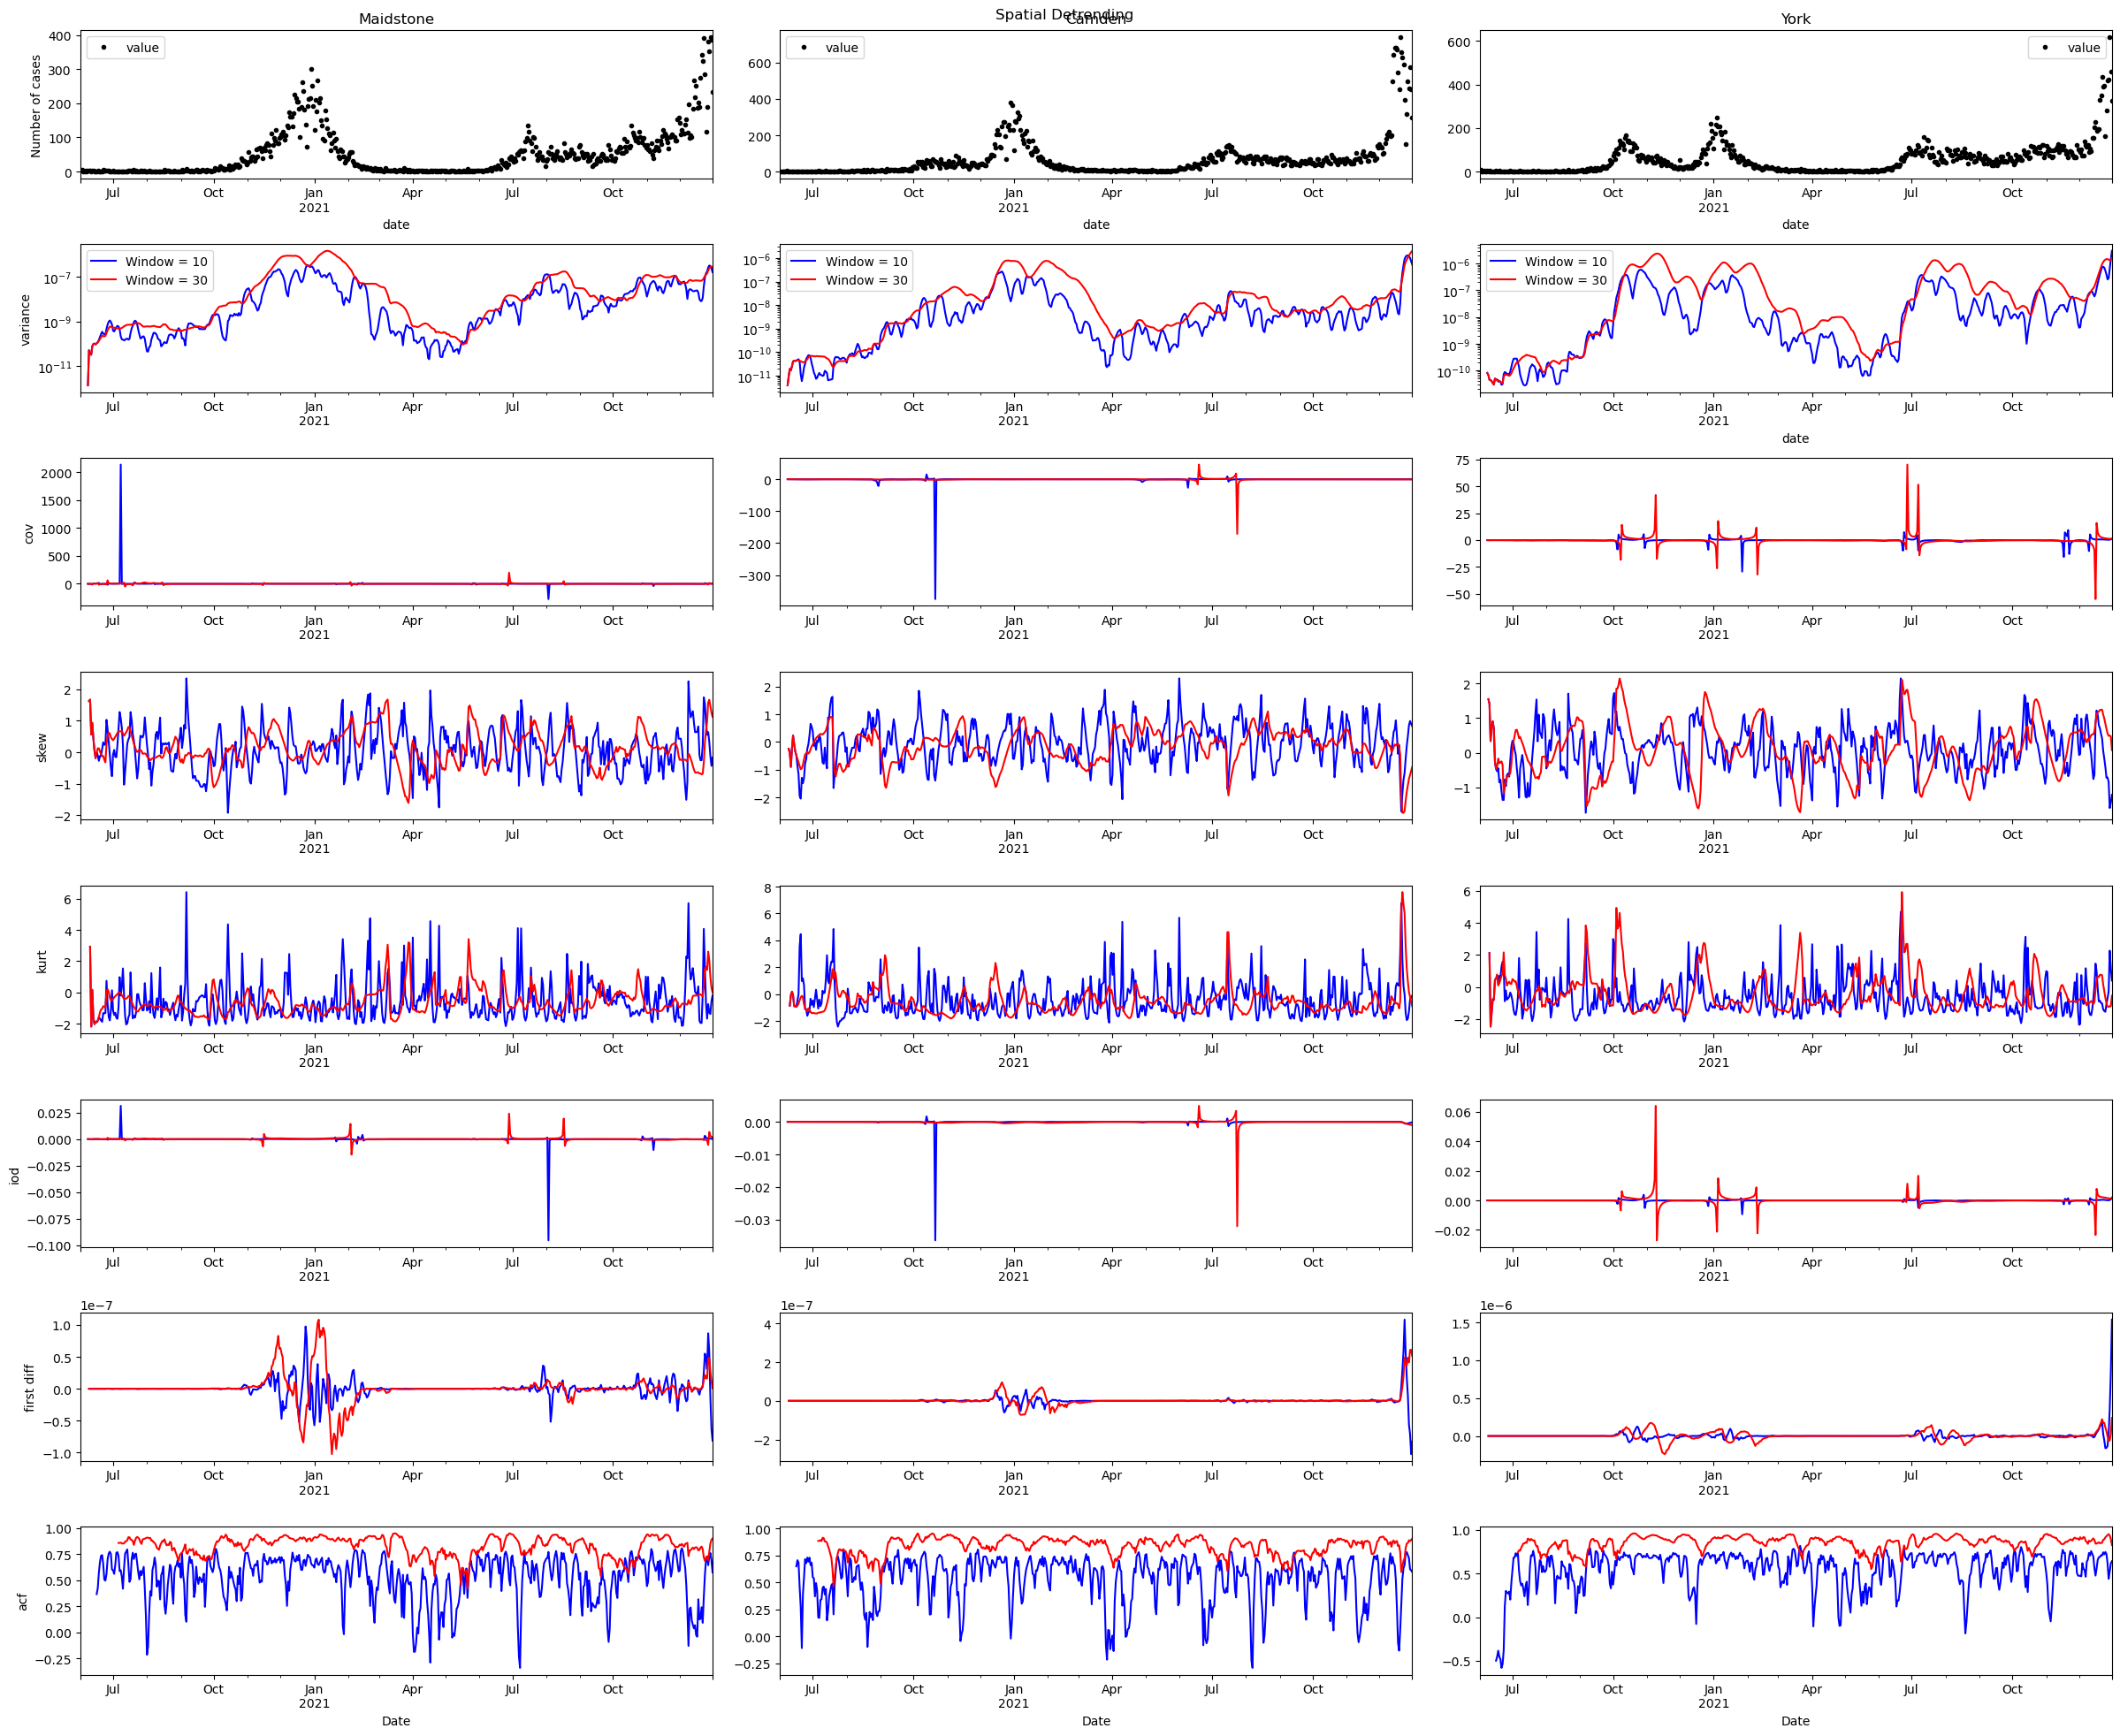

In [37]:
fig, axs = plt.subplots(nrows=len(ews_10total.keys())+1,ncols=3,figsize=(24,20))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')


for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_30total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,0],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,0],logy=True,color='red',label='Window = 30')
        axs[i+1,0].legend()
    else:
        y_data.plot(ax=axs[i+1,0],color='blue')
        x_data.plot(ax=axs[i+1,0],color='red')
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_30total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,1],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,1],logy=True,color='red',label='Window = 30')
        axs[i+1,1].legend()
    else:
        y_data.plot(ax=axs[i+1,1],color='blue')
        x_data.plot(ax=axs[i+1,1],color='red')
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['York']
    stat_data = ews_30total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,2],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,2],logy=True,color='red',label='Window = 30')
        axs[i+1,2].legend()
    else:
        y_data.plot(ax=axs[i+1,2],color='blue')
        x_data.plot(ax=axs[i+1,2],color='red')
        axs[i+1,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/spatialrolling1030.pdf",dpi=2400,bbox_inches='tight')
plt.show()